## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [157]:
# pandas and numpy

import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

import nltk #to add words to stop words
import re
import string

# textblob
from textblob import TextBlob

# model preparation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#set seed
import random
random.seed(10)

#word clouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#topic modeling
from sklearn.decomposition import LatentDirichletAllocation

In [158]:
#import file 
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [159]:
#check the size of the dataset
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (946791, 16)


In [160]:
#subset the data
## fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(frac=0.01, random_state=0)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
637157,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
148554,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
373598,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
811015,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
582485,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [161]:
#reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 16)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437"
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869"
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843"
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431"


In [162]:
#text data
congress_tweets['text'].head()

0    All of #OH14 salutes you, Patrolman St. Clair!...
1    In Case You Missed It: Bipartisanship works – ...
2    Wishing a happy #Passover to all those celebra...
3    RT @WhiteHouse President @realDonaldTrump just...
4    I just sent a letter demanding the Administrat...
Name: text, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [163]:
#replace all independents as democrats 
congress_tweets['party']=congress_tweets['party'].replace(r"Independent", "Democrat", regex=True)

In [164]:
#Remove emojis
def rem_emoji(text):
    emoji_pattern = re.compile("["
                            u"\U0001F600-\U0001F64F"  # emoticons
                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            u"\U00002500-\U00002BEF"  # chinese char
                            u"\U00002702-\U000027B0"
                            u"\U00002702-\U000027B0"
                            u"\U000024C2-\U0001F251"
                            u"\U0001f926-\U0001f937"
                            u"\U00010000-\U0010ffff"
                            u"\u2640-\u2642" 
                            u"\u2600-\u2B55"
                            u"\u200d"
                            u"\u23cf"
                            u"\u23e9"
                            u"\u231a"
                            u"\ufe0f"  # dingbats
                            u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#passing the emoji function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_emoji)

In [165]:
#Remove line breaks 
def rem_lbreaks(text):
    line_breaks = re.compile('\n')
    return line_breaks.sub(r'', text)

#Passing function to 'text'
congress_tweets['text'] = congress_tweets['text'].apply(rem_lbreaks)

In [166]:
#Remove urls
def rem_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#Passing the function to 'text' 
congress_tweets['text'] = congress_tweets['text'].apply(rem_urls)

In [167]:
#create rem_punc_stop() function
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt") 
    nlp.Defaults.stop_words.add("qt") 
    nlp.Defaults.stop_words.add("amp") 
    nlp.Defaults.stop_words.add("need") #NE: to get rid of the word "need" big on all wordclouds 
    nlp.Defaults.stop_words.add("today") #NE: to get rid of the word "today" big on all wordclouds  
    nlp.Defaults.stop_words.add("thank")
    
    punc = set(punctuation)
    punc.add('–')
    punc.add('“')
    punc.add("‘")
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    #create tokens
    spacy_words = [token.text.lower() for token in doc] #to make the text all lower case 

    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc


In [168]:
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index(drop = True)  #remove missing values

In [169]:
#use the map() function to apply our rem_punc_stop function to every row of our dataframe
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x)) # x = each item in the 'text'
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head(30)

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, , fox8..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, , bill,..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da..."
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ..."
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson..."
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp..."
9,1.222750e+18,RepValDemings,2020-01-29T23:59:40-05:00,“This nation will remain the land of the free ...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447","[nation, remain, land, free, long, home, brave..."


In [170]:
#Remove blank spaces
def rem_spaces(text):
    text = [item.strip(' ') for item in text]  #removes white spaces in each item
    return [item for item in text if item]  #removes items that are empty strings

#Passing function to 'tokens'
congress_tweets['tokens'] = congress_tweets['tokens'].apply(rem_spaces)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9468, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [171]:
#Remove tweets with no words 
congress_tweets = congress_tweets[congress_tweets['tokens'].map(lambda x: len(x) > 0)].reset_index(drop = True)
print("Shape of current df:", congress_tweets.shape)
congress_tweets.head()

Shape of current df: (9433, 17)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news..."
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er..."
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,..."
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe..."
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop..."


In [172]:
congress_tweets['tokens'][0] # text string -> tokens in list form

['oh14',
 'salutes',
 'patrolman',
 'st',
 'clair',
 'fox8news',
 '5yearold',
 'battling',
 'cancer',
 'bainbridge',
 'police',
 'officer',
 'day',
 'rooseveltlfox8']

In [173]:
#get rid of tokens that are bracket
congress_tweets['length_tokens']=congress_tweets['tokens'].str.len()
congress_tweets=pd.DataFrame(congress_tweets[congress_tweets['length_tokens']>2])
print("Shape of current df:", congress_tweets.shape)

Shape of current df: (9332, 18)


In [175]:
#Length of smallest tweet
congress_tweets['tokens'].str.len().min()

3

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

## EDA 1. WordClouds

In [178]:
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(text)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:5])
print(list(rel_freq.items())[:5])

[('american', 619), ('work', 555), ('new', 548), ('help', 526), ('time', 525)]
[('american', 1.0), ('work', 0.8966074313408724), ('new', 0.8852988691437803), ('help', 0.8497576736672051), ('time', 0.8481421647819063)]


In [174]:
# EG: it looks like "today", "american", "need", "work", "day", "week", "year", "help", and "support" are (will be?) useless

#MJK/NE
Based on the highest word frequencies we inspected the word clouds and determined that we should not remove these words because they are prevalent for some parties and positions but not others. 

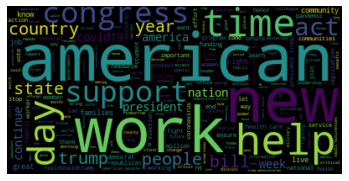

In [176]:
#WordCloud(ALL)

# Convert list of tokens back to text string
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [21]:
#Table - political party-Republicans

congress_tweets_R = congress_tweets[(congress_tweets['party']=='Republican')]
print("Shape of current df:", congress_tweets_R.shape)
congress_tweets_R.head()

Shape of current df: (353, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


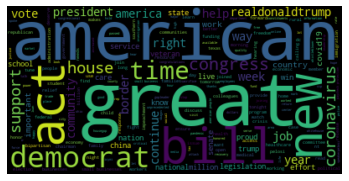

In [182]:
#WordCloud for Republicans

# Convert list of tokens back to text string
text_R = ' '.join(congress_tweets_R['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_R) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [183]:
#Table - political party-Democrats

congress_tweets_D = congress_tweets[(congress_tweets['party']=='Democrat')]
print("Shape of current df:", congress_tweets_D.shape)
congress_tweets_D.head()

Shape of current df: (5966, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


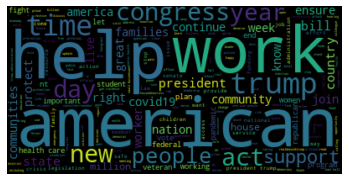

In [184]:
##WordCloud for Democrats
# Convert list of tokens back to text string
text_D = ' '.join(congress_tweets_D['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_D) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [185]:
#Table - Legislator position-Senator

congress_tweets_sen = congress_tweets[congress_tweets["position"]=="Sen"]
print("Shape of current df:", congress_tweets_sen.shape)
congress_tweets_sen.head()

Shape of current df: (2226, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
12,1.105870e+18,SenatorSinema,2019-03-13T12:36:37-04:00,"Among public institutions, @ASU is third in th...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[public, institutions, asu, nation, student, f...",12
24,1.249040e+18,SenatorSinema,2020-04-11T14:19:58-04:00,"Arizonans: if you've lost your job, been furlo...",Kyrsten Sinema,Sen,3-Jan-19,7/12/1976,F,AZ,Senate,Democrat,"1,252,401","1,161,167","1,025,232","1,233,654","[arizonans, ve, lost, job, furloughed, hours, ...",20
28,1.105590e+18,MartinHeinrich,2019-03-12T18:15:17-04:00,Proud that my bipartisan bill with @SenAlexand...,Martin Heinrich,Sen,3-Jan-13,10/17/1971,M,NM,Senate,Democrat,"319,667","385,234","415,335","335,788","[proud, bipartisan, bill, senalexander, signed...",22
34,1.105460e+18,PattyMurray,2019-03-12T09:12:00-04:00,ICYMI: The latest #TrumpBudget has massive tax...,Patty Murray,Sen,3-Jan-17,10/11/1950,F,WA,Senate,Democrat,"1,221,747","1,742,718","1,755,396","1,290,670","[icymi, latest, trumpbudget, massive, tax, bre...",22
35,1.186770e+18,McConnellPress,2019-10-22T18:12:22-04:00,RT @ARCgov ARC Federal Co-Chairman Tim Thomas:...,Mitch McConnell,Sen,3-Jan-15,2/20/1942,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190","[arcgov, arc, federal, cochairman, tim, thomas...",22


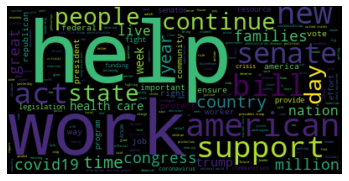

In [186]:
##WordCloud for Senators
# Convert list of tokens back to text string
text_sen = ' '.join(congress_tweets_sen['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_sen) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [187]:
#Table - Legislator position- House of Representatives 

congress_tweets_hrep = congress_tweets[congress_tweets["position"]=="Rep"]
print("Shape of current df:", congress_tweets_hrep.shape)
congress_tweets_hrep.head()

Shape of current df: (7106, 18)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22


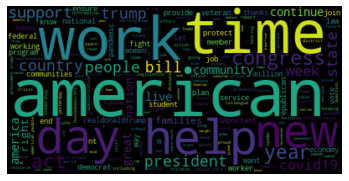

In [188]:
##WordCloud for House of Representatives
# Convert list of tokens back to text string
text_hrep = ' '.join(congress_tweets_hrep['tokens'].map(lambda text: ' '.join(text))) #join every item with space

# feed string to wordcloud
wordcloud = WordCloud().generate(text_hrep) #wordcloud library

# plot!
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## MJK - FIX TEXT THURSDAY

## Wordcloud shows that the most frequently used words do not vary a lot by party(e.g., today, thank, american). However, it shows that the republicans use "great" and "new" more frequently, while democrats use "healthcare" and "communities" more frequently- which is expected.

## Wordcloud also shows that both Senates and Representatives use "today" and "need" a lot. But Senates use "work" more often while Representatives use "thank" more often.

## EDA 2. Topic modeling 

In [189]:
#TASK 3: GENERAL MODEL (1), REDO TOPIC MODELING PER PARTY (2), PER POSITION (2)
# add column where tokens are concatenated into a single string
congress_tweets['tokens_str'] = congress_tweets['tokens'].str.join(" ")
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,5,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,Senate,Republican,"700,714","485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,5,Democrat,"673,215","897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard


In [190]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [192]:
# create new variables to loop LDA

congress_tweets['tweets_R'] = ' ' 
congress_tweets.loc[congress_tweets['party']=='Republican', 'tweets_R'] = congress_tweets['text']

congress_tweets['tweets_D'] = ' '
congress_tweets.loc[congress_tweets['party']=='Democrat', 'tweets_D'] = congress_tweets['text']

congress_tweets['tweets_Sen'] = ' '
congress_tweets.loc[congress_tweets['position']=='Sen', 'tweets_Sen'] = congress_tweets['text']

congress_tweets['tweets_HRep'] = ' ' 
congress_tweets.loc[congress_tweets['position']=='Rep', 'tweets_HRep'] = congress_tweets['text']

congress_tweets.tail(10)  # check new variables 

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep
9423,1.119350e+18,RepRickLarsen,2019-04-19T17:24:58-04:00,Visited @Castle_Cooke to hear abt how it suppo...,Rick Larsen,Rep,3-Jan-01,6/15/1965,M,WA,...,"1,742,718","1,755,396","1,290,670","[visited, castlecooke, hear, abt, supports, ge...",26,visited castlecooke hear abt supports general ...,,Visited @Castle_Cooke to hear abt how it suppo...,,Visited @Castle_Cooke to hear abt how it suppo...
9424,1.278700e+18,RepAndyBiggsAZ,2020-07-02T10:44:14-04:00,"@realDonaldTrump As our economy is restored, i...",Andy Biggs,Rep,3-Jan-17,11/7/1958,M,AZ,...,"1,161,167","1,025,232","1,233,654","[realdonaldtrump, economy, restored, imperativ...",11,realdonaldtrump economy restored imperative pr...,"@realDonaldTrump As our economy is restored, i...",,,"@realDonaldTrump As our economy is restored, i..."
9425,1.250090e+18,RepEliotEngel,2020-04-14T11:50:55-04:00,"RT @HouseForeign ""In March '19, Trump cut off ...",Eliot Engel,Rep,3-Jan-89,2/18/1947,M,NY,...,"4,556,118","4,485,741","2,490,431","[houseforeign, march, 19, trump, cut, aidi, el...",44,houseforeign march 19 trump cut aidi el salvad...,,"RT @HouseForeign ""In March '19, Trump cut off ...",,"RT @HouseForeign ""In March '19, Trump cut off ..."
9426,1.137100e+18,RepDanKildee,2019-06-07T17:00:00-04:00,Got the chance to check out @MottCollege’s new...,Dan Kildee,Rep,3-Jan-13,8/11/1958,M,MI,...,"2,268,839","2,564,569","2,115,256","[got, chance, check, mottcollege, new, culinar...",23,got chance check mottcollege new culinary arts...,,Got the chance to check out @MottCollege’s new...,,Got the chance to check out @MottCollege’s new...
9427,1.284560e+18,BradSherman,2020-07-18T14:58:10-04:00,From when I joined Congress &amp; began workin...,Brad Sherman,Rep,3-Jan-97,10/24/1954,M,CA,...,"8,753,792","7,854,285","4,839,958","[joined, congress, began, working, joining, ce...",23,joined congress began working joining celebrat...,,From when I joined Congress &amp; began workin...,,From when I joined Congress &amp; began workin...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,"380,494","394,409","647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...,Our greatest strength lies within our love for...,,,Our greatest strength lies within our love for...
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,...,"4,556,118","4,485,741","2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...,,"RT @davidaxelrod What a leader would say:Yes, ...",,"RT @davidaxelrod What a leader would say:Yes, ..."
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,...,"485,131","562,949","710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...,RT @tatereeves The Chicago mayor says Mississi...,,RT @tatereeves The Chicago mayor says Mississi...,
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,...,"897,572","905,083","634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard,,Tomorrow is #ElectionDay. Make sure to get out...,,Tomorrow is #ElectionDay. Make sure to get out...
9432,1.250810e+18,GOPLeader,2020-04-16T11:32:26-04:00,We are navigating one of the toughest challeng...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,...,"8,753,792","7,854,285","4,839,958","[navigating, t

In [206]:
# loop through each of the five variables containing tweets and create five topic models for each
new_vars = ["text", "tweets_R", "tweets_D", "tweets_Sen", "tweets_HRep"]
titles = ["All", "Republican", "Democrat", "Senate", "House of Rep"]
topics= [] # initialize empty list to add topic dfs to 
for var,n in zip(new_vars,titles): 
    X = congress_tweets[var]
    tf = TfidfVectorizer(tokenizer = rem_punc_stop) #creating an object : tf model
    tfidf_matrix =  tf.fit_transform(X) #downweigh the common words & upweigh the rare words
    dense_matrix = tfidf_matrix.todense() #remove all the columns where there are 0
    lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0) #initialize model/ prespecify the parameter n => "5 topics",  #random_state for reproducibility
    lda = lda.fit(dense_matrix) # pass through our dense matrix
    tf_feature_names = tf.get_feature_names()
    print("The topics for " + n + " are: ")
    print_top_words(lda, tf_feature_names, 20) #prints out top words using different objects attached to our lda model
    topic_dist = lda.transform(tfidf_matrix) #get the topic distribution array
    topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)
    #df_w_topics = topic_dist_df.join(congress_tweets.reset_index(drop = True)) #merge back with original dataframe, drop missing and reset index
    topics.append(topic_dist_df)

The topics for All are: 

Topic #0:
  town hall de telephone live covid19 pm information la newsletter el questions    join app friday     submit cases

Topic #1:
  small apply businesses visit health medicare information help care program irs coverage payment payments preexisting business great covid19 deadline

Topic #2:
  trump people president act house congress health work american americans time help bill covid19 new country support families —

Topic #3:
happy wishing birthday hong kong de friday easter privilege buildthewall courts usnavy luther la 245th en independenceday phoenix nationaldebt senrickscott

Topic #4:
added unborn hide india great housecommerce expectations baby uschamber prolife endinfanticide cnbc reuters jobsreport prayer catch enterprise friday chosen bridges

The topics for Republican are: 

Topic #0:
  ch ho tensions natchez changed 30000000000001815 pages46 pathway detective premiums kingabdullahii indefinitely email lowerhealthcarecosts muellerdossier ⁦by

In [211]:
topics = pd.concat([topics[0],
                    topics[1],
                    topics[2], 
                    topics[3],
                    topics[4]], axis=1)

topics.head()

,0,1,2,3,4,0,1,2,3,4,...,0,1,2,3,4,0,1,2,3,4
0,0.041770,0.041764,0.271474,0.041807,0.603185,0.045072,0.041389,0.041387,0.830120,0.042032,...,0.6,0.1,0.1,0.1,0.1,0.569484,0.305439,0.041920,0.041594,0.041563
1,0.050132,0.050124,0.799539,0.050088,0.050117,0.599990,0.100000,0.100000,0.100009,0.100001,...,0.6,0.1,0.1,0.1,0.1,0.052447,0.797276,0.050101,0.050069,0.050107
2,0.064103,0.059265,0.066861,0.750580,0.059190,0.599990,0.100000,0.100000,0.100009,0.100001,...,0.6,0.1,0.1,0.1,0.1,0.058997,0.762796,0.060139,0.059062,0.059007
3,0.045399,0.046438,0.626068,0.236437,0.045659,0.051800,0.045116,0.045115,0.812600,0.045369,...,0.6,0.1,0.1,0.1,0.1,0.048460,0.636280,0.224420,0.045523,0.045318
4,0.035508,0.035679,0.857800,0.035507,0.035507,0.599990,0.100000,0.100000,0.100009,0.100001,...,0.6,0.1,0.1,0.1,0.1,0.036140,0.857458,0.035472,0.035464,0.035465


In [37]:
df_w_topics

,0,1,2,3,4,index,tweet_id,screen_name,datetime,text,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens,tokens_str
0,0.829102,0.042562,0.042632,0.042857,0.042848,0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",...,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...
1,0.051439,0.051712,0.793169,0.051636,0.052044,1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,...,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...
2,0.059199,0.058698,0.763138,0.059837,0.059128,2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,...,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight
3,0.045626,0.816094,0.045847,0.046553,0.045880,3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,...,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...
4,0.035956,0.035997,0.036043,0.856055,0.035949,4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,...,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929,0.034704,0.035053,0.034832,0.860833,0.034578,936,1.188800e+18,SteveScalise,2019-10-28T08:59:34-04:00,RT @RepArrington 1 million #jobs in Texas depe...,...,LA,1,Republican,"1,178,638","780,154","809,141","1,152,262","[reparrington, 1, million, jobs, texas, depend...",26,reparrington 1 million jobs texas depend trade...
930,0.045779,0.817142,0.045455,0.045869,0.045755,937,1.260320e+18,Sen_JoeManchin,2020-05-12T17:25:11-04:00,I urge Governor Justice to please distribute a...,...,WV,Senate,Democrat,"489,371","188,794","238,269","417,655","[urge, governor, justice, distribute, share, 1...",12,urge governor justice distribute share 125 bil...
931,0.042490,0.042197,0.042148,0.042080,0.831085,938,1.262910e+18,RepCheri,2020-05-19T21:03:04-04:00,“We need help in the ag industry; we need help...,...,IL,17,Democrat,"2,146,015","3,090,729","3,019,512","2,135,216","[help, ag, industry, help, family, farmers, ”,...",16,help ag industry help family farmers ” proud w...
932,0.852844,0.036750,0.036651,0.036994,0.036760,939,1.204160e+18,SusanWBrooks,2019-12-09T17:07:34-05:00,“Ignosi” is an application that revolutionizes...,...,IN,5,Republican,"1,557,286","1,033,126","1,152,887","1,420,543","[ignosi, ”, application, revolutionizes, proce...",23,ignosi ” application revolutionizes process fi...



## MJK All 10 topics do not seem to have a lot of separation between senators and representatives

#MJK/NE: visualizations don't make sense because the topics are different, how do we compare the without visualizations? WE WILL ASK KQ
 

LinAlgError: singular matrix

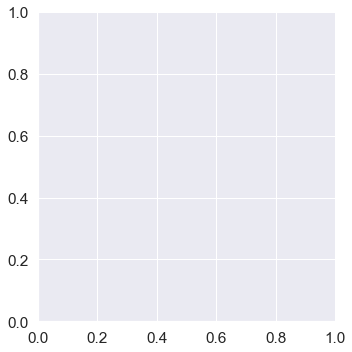

In [212]:
# # Visualization- Topic 1 - for position
# sns.displot(df_w_topics, x=df_w_topics[0], hue = "position", kind = 'kde', fill = 'true')
# plt.show()

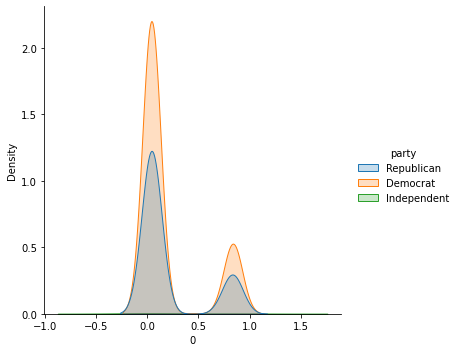

In [41]:
# # Visualization- Topic 1 - for party 
# sns.displot(df_w_topics, x=df_w_topics[0], hue = "party", kind = 'kde', fill = 'true')
# plt.show()

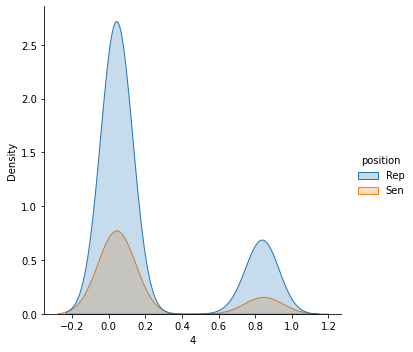

In [42]:
# # Visualization- Topic 5 - for position
# sns.displot(df_w_topics, x=df_w_topics[4], hue = "position", kind = 'kde', fill = 'true')
# plt.show()

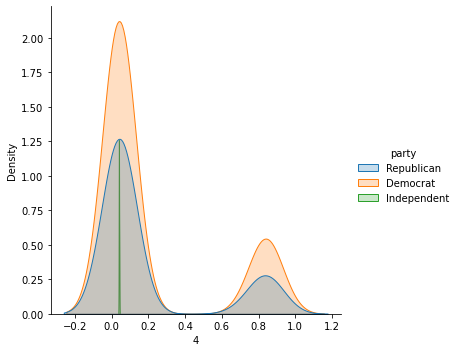

In [43]:
# # Visualization- Topic 5 - for party 
# sns.displot(df_w_topics, x=df_w_topics[4], hue = "party", kind = 'kde', fill = 'true')
# plt.show()


## MJK:

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## 1) Exploration: Overall

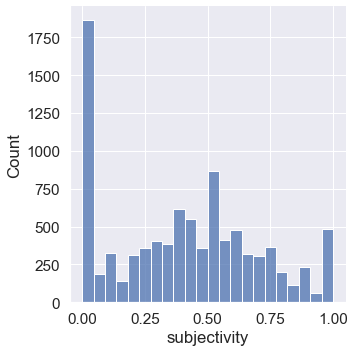

In [213]:
#check subjectivity for all tweets 
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sns.displot(congress_tweets, x="subjectivity")
plt.show()

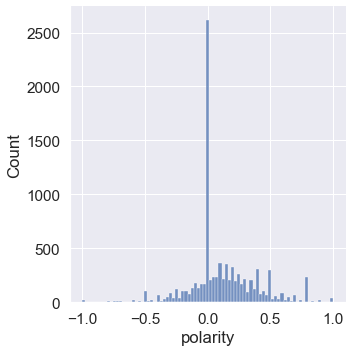

In [214]:
#check sentiment/polarity for all tweets 
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
sns.displot(congress_tweets, x="polarity")
plt.show()

In [215]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,"All of #OH14 salutes you, Patrolman St. Clair!...",,,"All of #OH14 salutes you, Patrolman St. Clair!...",0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,In Case You Missed It: Bipartisanship works – ...,,In Case You Missed It: Bipartisanship works – ...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,Wishing a happy #Passover to all those celebra...,,Wishing a happy #Passover to all those celebra...,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,RT @WhiteHouse President @realDonaldTrump just...,,,RT @WhiteHouse President @realDonaldTrump just...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,I just sent a letter demanding the Administrat...,,I just sent a letter demanding the Administrat...,1.0,-0.166667


##  NE FIX TOMORROW
## Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Although the overall distribution is normal, more tweets were factual information(subjectivity ==0) compared to opinions(subjectivity ==1).

## 2) Choose two legislators, one liberal and one conservative

In [216]:
# Republican: David Joyce
congress_tweets_R.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,14,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,14,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[whitehouse, president, realdonaldtrump, signe...",12
6,1.311670e+18,RepMcCaul,2020-10-01T10:21:28-04:00,RT @HouseGOP It's time to get serious about ho...,Michael McCaul,Rep,3-Jan-05,1/14/1962,M,TX,10,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[housegop, time, holding, china, accountable, ...",23
7,1.244250e+18,RepStefanik,2020-03-29T08:48:34-04:00,RT @wdtnews With five confirmed COVID-19 cases...,Elise Stefanik,Rep,3-Jan-15,7/2/1984,F,NY,21,Republican,"2,819,533","4,556,118","4,485,741","2,490,431","[wdtnews, confirmed, covid19, cases, jefferson...",20
13,1.340700e+18,GOPLeader,2020-12-20T11:50:36-05:00,There is no way Eric Swalwell should continue ...,Kevin McCarthy,Rep,3-Jan-07,1/26/1965,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958","[way, eric, swalwell, continue, serve, house, ...",8


In [217]:
congress_tweets_DavidJoyce = congress_tweets[congress_tweets["name_wikipedia"]=="David Joyce"].copy()

congress_tweets_DavidJoyce

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,"All of #OH14 salutes you, Patrolman St. Clair!...",,,"All of #OH14 salutes you, Patrolman St. Clair!...",0.00000,0.000000
2007,1.166760e+18,RepDaveJoyce,2019-08-28T13:29:18-04:00,"As the son of a wounded WWII vet, I applaud @P...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[son, wounded, wwii, vet, applaud, potus, deci...",22,son wounded wwii vet applaud potus decision ca...,"As the son of a wounded WWII vet, I applaud @P...",,,"As the son of a wounded WWII vet, I applaud @P...",0.15000,-0.100000
3106,1.161730e+18,RepDaveJoyce,2019-08-14T15:49:18-04:00,Always honored to speak at the annual 3chamber...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[honored, speak, annual, 3chamber, luncheon, s...",29,honored speak annual 3chamber luncheon spoke 1...,Always honored to speak at the annual 3chamber...,,,Always honored to speak at the annual 3chamber...,0.25000,-0.125000
3509,1.304440e+18,RepDaveJoyce,2020-09-11T11:06:06-04:00,Godspeed Detective QT @wkyc A sea of police o...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[godspeed, detective, wkyc, sea, police, offic...",14,godspeed detective wkyc sea police officers le...,Godspeed Detective QT @wkyc A sea of police o...,,,Godspeed Detective QT @wkyc A sea of police o...,0.00000,0.000000
3929,1.268180e+18,RepDaveJoyce,2020-06-03T09:44:48-04:00,RT @AmChemMatters Ohio chemistry has stepped u...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[amchemmatters, ohio, chemistry, stepped, help...",27,amchemmatters ohio chemistry stepped help loca...,RT @AmChemMatters Ohio chemistry has stepped u...,,,RT @AmChemMatters Ohio chemistry has stepped u...,0.00000,0.000000
4411,1.316030e+18,RepDaveJoyce,2020-10-13T11:10:07-04:00,Looking forward to visiting this local manufac...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[looking, forward, visiting, local, manufactur...",21,looking forward visiting local manufacturer th...,Looking forward to visiting this local manufac...,,,Looking forward to visiting this local manufac...,0.27500,0.233333
4690,1.214590e+18,RepDaveJoyce,2020-01-07T11:56:51-05:00,"Good luck in your 2020 seasons, Cardinals! #c...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[good, luck, 2020, seasons, cardinals, cardsco...",23,good luck 2020 seasons cardinals cardscompete ...,"Good luck in your 2020 seasons, Cardinals! #c...",,,"Good luck in your 2020 seasons, Cardinals! #c...",0.60000,0.700000
6494,1.189640e+18,RepDaveJoyce,2019-10-30T16:34:52-04:00,Always honored and humbled to join @the_USO in...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[honored, humbled, join, theuso, assembling, c...",17,honored humbled join theuso assembling care pa...,Always honored and humbled to join @the_USO in...,,,Always honored and humbled to join @the_USO in...,0.00000,0.000000
6651,1.149330e+18,RepDaveJoyce,2019-07-11T10:58:15-04:00,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[energycommerce, hr, 728, title, viii, nursing...",19,energycommerce hr 728 title viii nursing workf...,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",,,"RT @EnergyCommerce Up next is H.R. 728, the Ti...",0.00000,0.000000
7462,1.288510e+18,RepDaveJoyce,2020-07-29T12:09:48-04:00,Great news for NEOH and the entire Buckeye Sta...,David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[great, news, neoh, entire, buckeye, state, us...",35,great news neoh entire buckeye state usdot fun...,Great 

In [218]:
#average subjectivity for David Joyce tweets
congress_tweets_DavidJoyce_meanS = congress_tweets_DavidJoyce["subjectivity"].mean()
print(congress_tweets_DavidJoyce_meanS)

0.23509615384615387


In [219]:
#average polarity for David Joyce tweets
congress_tweets_DavidJoyce_meanP = congress_tweets_DavidJoyce["polarity"].mean()
print(congress_tweets_DavidJoyce_meanP)

0.1455128205128205


## The overall subjectivity score for David Joyce(Republican) is 0.24 and the overall polarity score is 0.15 


In [220]:
# Democrat: Josh Harder
congress_tweets_D.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,length_tokens
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,10,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[case, missed, bipartisanship, works, bill, er...",9
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,5,Democrat,"943,169","1,677,928","1,677,844","971,869","[wishing, happy, passover, celebrating, seder,...",6
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,11,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[sent, letter, demanding, administration, stop...",22
5,1.117090e+18,RepWexton,2019-04-13T11:42:15-04:00,The President’s attacks on Rep. @Ilhan are dis...,Jennifer Wexton,Rep,3-Jan-19,5/27/1968,F,VA,10,Democrat,"1,769,443","1,981,473","1,971,820","1,822,522","[president, attacks, rep, ilhan, dishonest, da...",19
8,1.157440e+18,RepSwalwell,2019-08-02T19:47:23-04:00,"RT @SVLeadershipGrp ""We can only be game chang...",Eric Swalwell,Rep,3-Jan-13,11/16/1980,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[svleadershipgrp, game, changers, accept, resp...",18


In [221]:
congress_tweets_JoshHarder = congress_tweets[congress_tweets["name_wikipedia"]=="Josh Harder"].copy()
congress_tweets_JoshHarder

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,In Case You Missed It: Bipartisanship works – ...,,In Case You Missed It: Bipartisanship works – ...,0.000000,0.000000
173,1.275220e+18,RepJoshHarder,2020-06-22T20:00:00-04:00,Big thanks to the @USChamber for giving me the...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[big, thanks, uschamber, giving, spirit, enter...",16,big thanks uschamber giving spirit enterprise ...,,Big thanks to the @USChamber for giving me the...,,Big thanks to the @USChamber for giving me the...,0.366667,0.200000
856,1.333120e+18,RepJoshHarder,2020-11-29T14:00:01-05:00,Folks – tomorrow Congress is back in session –...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[folks, tomorrow, congress, session, blown, aw...",10,folks tomorrow congress session blown away sti...,,Folks – tomorrow Congress is back in session –...,,Folks – tomorrow Congress is back in session –...,0.000000,0.000000
1042,1.117520e+18,RepJoshHarder,2019-04-14T16:00:00-04:00,Wishing our Sikh neighbors and friends a happy...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[wishing, sikh, neighbors, friends, happy, vai...",6,wishing sikh neighbors friends happy vaisakhi,,Wishing our Sikh neighbors and friends a happy...,,Wishing our Sikh neighbors and friends a happy...,1.000000,0.800000
1637,1.328760e+18,RepJoshHarder,2020-11-17T13:00:00-05:00,"Folks – get a FREE Covid test today (Tuesday, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[folks, free, covid, test, tuesday, nov, 17, t...",16,folks free covid test tuesday nov 17 turlock p...,,"Folks – get a FREE Covid test today (Tuesday, ...",,"Folks – get a FREE Covid test today (Tuesday, ...",0.613333,0.186667
1680,1.321630e+18,RepJoshHarder,2020-10-28T22:00:00-04:00,Farmworkers in the Valley literally feed the c...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[farmworkers, valley, literally, feed, country...",12,farmworkers valley literally feed country glad...,,Farmworkers in the Valley literally feed the c...,,Farmworkers in the Valley literally feed the c...,1.000000,0.500000
1926,1.312560e+18,RepJoshHarder,2020-10-03T21:00:00-04:00,Human trafficking is disgusting and we have to...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[human, trafficking, disgusting, stamp, safety...",10,human trafficking disgusting stamp safety pled...,,Human trafficking is disgusting and we have to...,,Human trafficking is disgusting and we have to...,0.662963,-0.166667
2376,1.118270e+18,RepJoshHarder,2019-04-16T17:35:00-04:00,Every week I call people who write my office. ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[week, people, write, office, heard, week]",6,week people write office heard week,,Every week I call people who write my office. ...,,Every week I call people who write my office. ...,0.000000,0.000000
3353,1.132750e+18,RepJoshHarder,2019-05-26T16:30:00-04:00,"We need the trade war to end, but until then, ...",Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[trade, war, end, support, farmers, help]",6,trade war end support farmers help,,"We need the trade war to end, but until then, ...",,"We need the trade war to end, but until then, ...",0.000000,0.000000
3478,1.226980e+18,RepJoshHarder,2020-02-10T16:11:14-05:00,Thanks Darleen. Our veterans sacrificed life a...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[thanks, darleen, veterans, sacrificed, life, ...",8,thanks darleen veterans sacrificed life limb b...,,Thanks Darleen. Our veterans sacrificed life a...,,Thanks 

In [222]:
#average subjectivity for Josh Harder tweets
congress_tweets_JoshHarder_meanS = congress_tweets_JoshHarder["subjectivity"].mean()
print(congress_tweets_JoshHarder_meanS)

0.4644154882154883


In [223]:
#average polarity for Josh Harder tweets
congress_tweets_JoshHarder_meanP = congress_tweets_JoshHarder["polarity"].mean()
print(congress_tweets_JoshHarder_meanP)

0.21144242424242424


## The overall subjectivity score for Josh Harder (Democrat) is 0.46 and the overall polarity score is 0.21 

## 3-1)  compare Democrats v. Republicans 

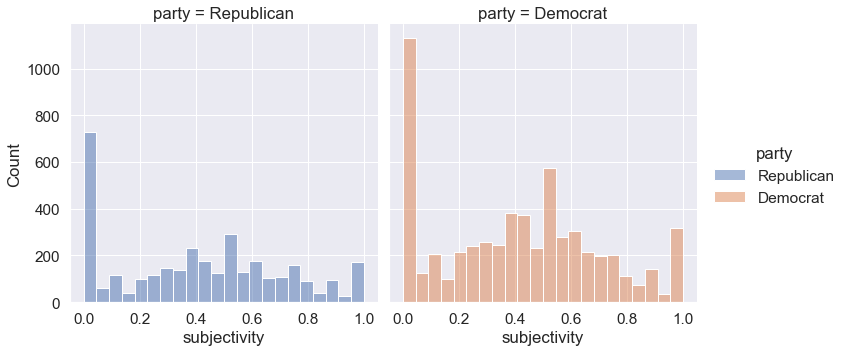

In [224]:
sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

In [ ]:
sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

## MJK/NE - INTERPRET

## 3-2) compare Senators v. Representatives 

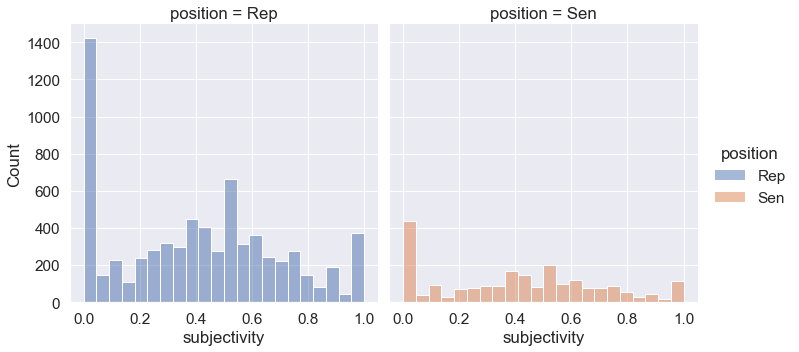

In [226]:
sns.displot(congress_tweets, x="subjectivity", hue = 'position', col = 'position')
plt.show()

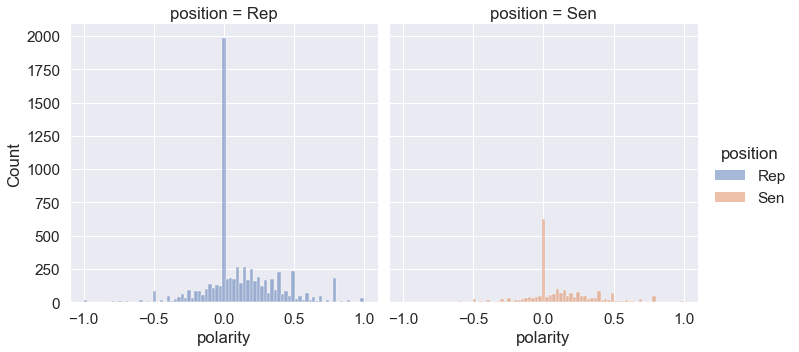

In [227]:
sns.displot(congress_tweets, x="polarity", hue = 'position', col = 'position')
plt.show()

## MJK/NE - INTERPRET

## Representatives tend to post more factual information(subjectivity ==0) than Senators

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [228]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'length_tokens', 'tokens_str',
       'tweets_R', 'tweets_D', 'tweets_Sen', 'tweets_HRep', 'subjectivity',
       'polarity'],
      dtype='object')

### Engineered Text Features

In [229]:
# Engineered Features
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

# Topic Model + Engineered Features
engineered_features_with_topics = topic_dist_df.join(engineered_features.reset_index(drop = True))

In [230]:
engineered_features_with_topics.head() # check first few rows of df with engineered text feats

,0,1,2,3,4,polarity,subjectivity
0,0.569484,0.305439,0.041920,0.041594,0.041563,0.000000,0.0
1,0.052447,0.797276,0.050101,0.050069,0.050107,0.000000,0.0
2,0.058997,0.762796,0.060139,0.059062,0.059007,0.800000,1.0
3,0.048460,0.636280,0.224420,0.045523,0.045318,0.000000,0.0
4,0.036140,0.857458,0.035472,0.035464,0.035465,-0.166667,1.0


### Bag-of-words or Tf-idf

In [231]:
# Frequency Based featurization
X = congress_tweets['tokens_str']
tf = TfidfVectorizer()

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

In [232]:
tfidf_df.head()

,03,08232020,082419,0amazon,0coors,0gm,0we,10,100,1000,...,zuckbuck,zuckerberg,zulfikar,zurfluh,ángeles,áreas,ōlelo,תודה,مبارک,نوروز
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
X.head(30)


0     oh14 salutes patrolman st clair fox8news 5year...
1     case missed bipartisanship works bill eradicat...
2      wishing happy passover celebrating seder tonight
3     whitehouse president realdonaldtrump signed bi...
4     sent letter demanding administration stop play...
5     president attacks rep ilhan dishonest dangerou...
6     housegop time holding china accountable china ...
7     wdtnews confirmed covid19 cases jefferson coun...
8     svleadershipgrp game changers accept responsib...
9     nation remain land free long home brave ” elme...
10    true address soon thehill charitable giving am...
11    preach shondarhimes homeschooling 6year old 8y...
12    public institutions asu nation student fulbrig...
13    way eric swalwell continue serve house intelli...
14    air sethleibsohn talk todays developments impe...
15    whistleblower reportedly worked joe biden ukra...
16    montclairnjgov essex county satellite testing ...
17    know lot concern food supply chain bay are

In [234]:
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,"All of #OH14 salutes you, Patrolman St. Clair!...",,,"All of #OH14 salutes you, Patrolman St. Clair!...",0.000000,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,In Case You Missed It: Bipartisanship works – ...,,In Case You Missed It: Bipartisanship works – ...,0.000000,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,Wishing a happy #Passover to all those celebra...,,Wishing a happy #Passover to all those celebra...,1.000000,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,RT @WhiteHouse President @realDonaldTrump just...,,,RT @WhiteHouse President @realDonaldTrump just...,0.000000,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,I just sent a letter demanding the Administrat...,,I just sent a letter demanding the Administrat...,1.000000,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,...,"647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...,Our greatest strength lies within our love for...,,,Our greatest strength lies within our love for...,0.598609,0.431725
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,Rep,3-Feb-98,9/25/1953,M,NY,...,"2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...,,"RT @davidaxelrod What a leader would say:Yes, ...",,"RT @davidaxelrod What a leader would say:Yes, ...",0.650000,-0.550000
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,Sen,9-Apr-18,5/10/1959,F,MS,...,"710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...,RT @tatereeves The Chicago mayor says Mississi...,,RT @tatereeves The Chicago mayor says Mississi...,,0.678571,-0.271429
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,Rep,3-Jan-19,3/8/1973,F,CT,...,"634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard,,Tomorrow is #ElectionDay. Make sure to get out...,,Tomorrow is #ElectionDay. Make sure to get out...,0.888889,0.500000


### Word Embedding - N STOPPED HERE 

In [235]:
#Using the function to re-tokenize
# congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

#Create word embedding model
model = gensim.models.Word2Vec(congress_tweets['tokens'], vector_size=100, window=3, \
                               min_count=5, sg=0, alpha=0.025, batch_words=10000)

In [236]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,Rep,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,"All of #OH14 salutes you, Patrolman St. Clair!...",,,"All of #OH14 salutes you, Patrolman St. Clair!...",0.0,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,Rep,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,In Case You Missed It: Bipartisanship works – ...,,In Case You Missed It: Bipartisanship works – ...,0.0,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,Rep,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,Wishing a happy #Passover to all those celebra...,,Wishing a happy #Passover to all those celebra...,1.0,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,Rep,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,RT @WhiteHouse President @realDonaldTrump just...,,,RT @WhiteHouse President @realDonaldTrump just...,0.0,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,Rep,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,I just sent a letter demanding the Administrat...,,I just sent a letter demanding the Administrat...,1.0,-0.166667


In [237]:
len(congress_tweets['tokens'][0])

14

In [238]:
doc = [word for word in congress_tweets['tokens'][0] if word in model.wv.index_to_key]
len(doc)

6

In [239]:
doc [0:5]

['st', 'battling', 'cancer', 'police', 'officer']

In [240]:
#Now let's grab the first vector each token and take their mean:
first_vec = []
for token in model.wv.__getitem__(doc):
    first_vec.append(token[0])
np.mean(first_vec)

-0.14674465

In [241]:
#create this for every word - get all the means (FROM LAB)
#Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#get an average embedding for each document 
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [242]:
# Initialize an array for the size of the corpus
#each word is represented by 100 element list, so then it averages the first element for each word across all the words
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    doc = [word for word in doc if word in model.wv.index_to_key]
    if len(doc)<1:
        continue
    empty_list_embeddings_means.append(document_vector(model, doc))
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [243]:
doc_average_embeddings

array([[-0.14674465,  0.22978546,  0.12421604, ..., -0.3635224 ,
         0.10719526,  0.03342836],
       [-0.10691795,  0.21953942,  0.09540969, ..., -0.31060684,
         0.10233976,  0.03920237],
       [-0.14512801,  0.22993878,  0.13260397, ..., -0.35230726,
         0.12108996,  0.03168332],
       ...,
       [-0.12587918,  0.20259026,  0.10816508, ..., -0.31071037,
         0.09880914,  0.02995187],
       [-0.18678105,  0.3029286 ,  0.15427127, ..., -0.4654057 ,
         0.13850051,  0.05357497],
       [-0.17104419,  0.29815242,  0.15412423, ..., -0.44935438,
         0.14413053,  0.0387321 ]], dtype=float32)

In [244]:
#AVE EMBEDDINGS FOR EACH DOC 
doc_average_embeddings.shape

(9326, 100)

In [245]:
#create dataframe
word2vec_features_df = pd.DataFrame(doc_average_embeddings) 
word2vec_features_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.146745,0.229785,0.124216,-0.099913,0.013787,-0.447909,0.025925,0.501151,-0.185361,-0.107134,...,0.327963,0.062141,0.097964,0.088244,0.389326,0.355580,0.137869,-0.363522,0.107195,0.033428
1,-0.106918,0.219539,0.095410,-0.090408,0.023953,-0.389275,-0.010212,0.448539,-0.166740,-0.092213,...,0.276843,0.063455,0.077334,0.076819,0.332690,0.287126,0.108400,-0.310607,0.102340,0.039202
2,-0.145128,0.229939,0.132604,-0.100604,0.007273,-0.442969,0.016162,0.510848,-0.184014,-0.102208,...,0.326203,0.056696,0.099580,0.091399,0.389013,0.363206,0.129626,-0.352307,0.121090,0.031683
3,-0.188384,0.356743,0.161335,-0.144323,0.024643,-0.619033,0.003979,0.703584,-0.269214,-0.153158,...,0.419640,0.098874,0.116364,0.116826,0.531964,0.447195,0.174707,-0.488535,0.176118,0.049611
4,-0.155514,0.243796,0.126211,-0.098271,0.015375,-0.460403,0.033104,0.514353,-0.185140,-0.110816,...,0.333510,0.072080,0.091897,0.094385,0.397268,0.356281,0.135939,-0.370765,0.106430,0.040101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9321,-0.166283,0.270493,0.142957,-0.118212,0.015976,-0.513340,0.024558,0.577350,-0.213456,-0.121945,...,0.376182,0.075871,0.109820,0.110954,0.445001,0.409135,0.160602,-0.413909,0.125417,0.038227
9322,-0.177449,0.264899,0.139231,-0.108727,0.021294,-0.498502,0.046917,0.559372,-0.194349,-0.115079,...,0.380823,0.083252,0.099263,0.112695,0.432822,0.398417,0.160507,-0.405081,0.108016,0.047290
9323,-0.125879,0.202590,0.108165,-0.078890,0.019169,-0.383400,0.024208,0.421783,-0.163632,-0.091245,...,0.268015,0.059638,0.078887,0.075416,0.330039,0.294333,0.117923,-0.310710,0.098809,0.029952
9324,-0.186781,0.302929,0.154271,-0.129115,0.019179,-0.576597,0.021371,0.648905,-0.240840,-0.132725,...,0.428702,0.098453,0.126059,0.129504,0.501133,0.457089,0.185101,-0.465406,0.138501,0.053575


## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [246]:
# collect the labels for party and chamber membership

lb_style = LabelBinarizer()
y_party = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])
    #0=Republican and 1=Democrat
y_chamber = congress_tweets['position'] =lb_style.fit_transform(congress_tweets['position'])
    #0=House of Rep and 1=Senate

In [247]:
y_party

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [248]:
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,...,romney_2012_state_share,tokens,length_tokens,tokens_str,tweets_R,tweets_D,tweets_Sen,tweets_HRep,subjectivity,polarity
0,1.183050e+18,RepDaveJoyce,2019-10-12T11:43:12-04:00,"All of #OH14 salutes you, Patrolman St. Clair!...",David Joyce,0,3-Jan-13,3/17/1957,M,OH,...,"2,661,437","[oh14, salutes, patrolman, st, clair, fox8news...",14,oh14 salutes patrolman st clair fox8news 5year...,"All of #OH14 salutes you, Patrolman St. Clair!...",,,"All of #OH14 salutes you, Patrolman St. Clair!...",0.000000,0.000000
1,1.314260e+18,RepJoshHarder,2020-10-08T14:00:01-04:00,In Case You Missed It: Bipartisanship works – ...,Josh Harder,0,3-Jan-19,8/1/1986,M,CA,...,"4,839,958","[case, missed, bipartisanship, works, bill, er...",9,case missed bipartisanship works bill eradicat...,,In Case You Missed It: Bipartisanship works – ...,,In Case You Missed It: Bipartisanship works – ...,0.000000,0.000000
2,1.119340e+18,LeaderHoyer,2019-04-19T16:22:37-04:00,Wishing a happy #Passover to all those celebra...,Steny Hoyer,0,19-May-81,6/14/1939,M,MD,...,"971,869","[wishing, happy, passover, celebrating, seder,...",6,wishing happy passover celebrating seder tonight,,Wishing a happy #Passover to all those celebra...,,Wishing a happy #Passover to all those celebra...,1.000000,0.800000
3,1.253750e+18,TXRandy14,2020-04-24T14:32:22-04:00,RT @WhiteHouse President @realDonaldTrump just...,Randy Weber,0,3-Jan-13,7/2/1953,M,TX,...,"4,569,843","[whitehouse, president, realdonaldtrump, signe...",12,whitehouse president realdonaldtrump signed bi...,RT @WhiteHouse President @realDonaldTrump just...,,,RT @WhiteHouse President @realDonaldTrump just...,0.000000,0.000000
4,1.232820e+18,RepMaxRose,2020-02-26T19:14:28-05:00,I just sent a letter demanding the Administrat...,Max Rose,0,3-Jan-19,11/28/1986,M,NY,...,"2,490,431","[sent, letter, demanding, administration, stop...",22,sent letter demanding administration stop play...,,I just sent a letter demanding the Administrat...,,I just sent a letter demanding the Administrat...,1.000000,-0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9428,1.093180e+18,RepFrenchHill,2019-02-06T11:28:17-05:00,Our greatest strength lies within our love for...,French Hill,0,3-Jan-15,12/5/1956,M,AR,...,"647,744","[greatest, strength, lies, love, repdebdingell...",30,greatest strength lies love repdebdingell john...,Our greatest strength lies within our love for...,,,Our greatest strength lies within our love for...,0.598609,0.431725
9429,1.305250e+18,RepGregoryMeeks,2020-09-13T17:07:09-04:00,"RT @davidaxelrod What a leader would say:Yes, ...",Gregory Meeks,0,3-Feb-98,9/25/1953,M,NY,...,"2,490,431","[davidaxelrod, leader, sayyes, face, deadly, p...",22,davidaxelrod leader sayyes face deadly pandemi...,,"RT @davidaxelrod What a leader would say:Yes, ...",,"RT @davidaxelrod What a leader would say:Yes, ...",0.650000,-0.550000
9430,1.296180e+18,SenHydeSmith,2020-08-19T16:28:15-04:00,RT @tatereeves The Chicago mayor says Mississi...,Cindy Hyde-Smith,1,9-Apr-18,5/10/1959,F,MS,...,"710,746","[tatereeves, chicago, mayor, says, mississippi...",44,tatereeves chicago mayor says mississippians b...,RT @tatereeves The Chicago mayor says Mississi...,,RT @tatereeves The Chicago mayor says Mississi...,,0.678571,-0.271429
9431,1.191400e+18,RepJahanaHayes,2019-11-04T11:42:37-05:00,Tomorrow is #ElectionDay. Make sure to get out...,Jahana Hayes,0,3-Jan-19,3/8/1973,F,CT,...,"634,892","[tomorrow, electionday, sure, voice, heard]",5,tomorrow electionday sure voice heard,,Tomorrow is #ElectionDay. Make sure to get out...,,Tomorrow is #ElectionDay. Make sure to get out...,0.888889,0.500000


### 1. Engineered features

In [249]:
print(len(congress_tweets))
print(len(engineered_features_with_topics))

9332
9332


#### 1.1 classify party

In [250]:
X_ef_p_train, X_ef_p_test, y_p_train, y_p_test = train_test_split(engineered_features_with_topics,
                                                                  y_party,
                                                                  train_size = 0.80,
                                                                  test_size= 0.20,
                                                                  random_state = 10)

In [251]:
print(len(X_ef_p_train))
print(len(y_p_train))
print(len(X_ef_p_test))
print(len(y_p_test))
print(X_ef_p_train.shape)
print(X_ef_p_test.shape)
print(y_p_train.shape)
print(y_p_test.shape)

7465
7465
1867
1867
(7465, 7)
(1867, 7)
(7465, 1)
(1867, 1)


In [252]:
y_p_test

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [253]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_ef_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

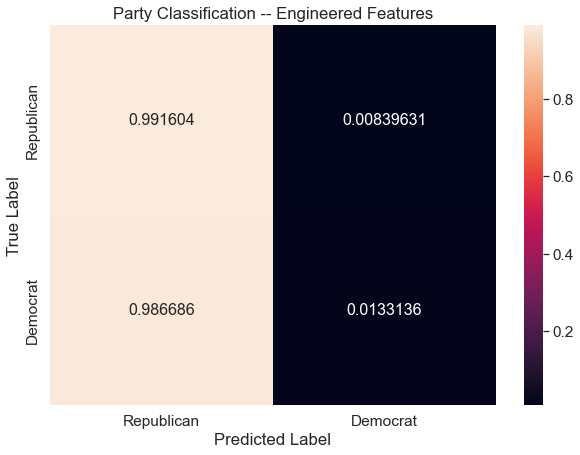

In [254]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 1.2 classify chamber

In [255]:
X_ef_c_train, X_ef_c_test, y_c_train, y_c_test = train_test_split(engineered_features_with_topics,
                                                                  y_chamber,
                                                                  train_size = .80,
                                                                  test_size=0.20,
                                                                  random_state = 10)

In [256]:
print(len(X_ef_c_train))
print(len(y_c_train))
print(len(X_ef_c_test))
print(len(y_c_test))

7465
7465
1867
1867


In [257]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_ef_c_train, y_c_train.ravel())

# create pedictions
y_c_pred = logit_model.predict(X_ef_c_test)

# create confusion matrix
cf_matrix_c = confusion_matrix(y_c_test, y_c_pred, normalize = "true")

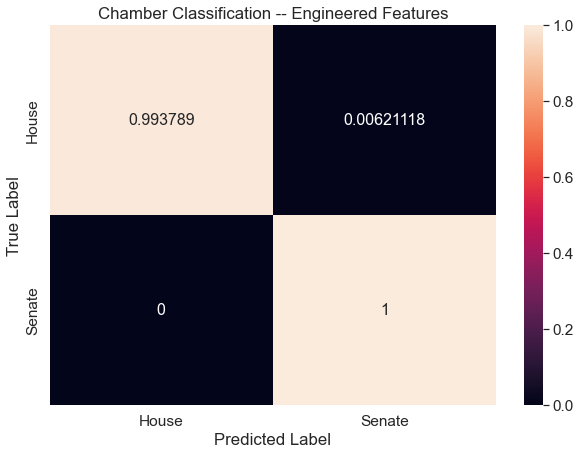

In [258]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_c, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "House", 1: "Senate"})
df_cm.index = ["House", "Senate"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Chamber Classification -- Engineered Features")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 2. tf-idf

#### 2.1 classify party

In [259]:
X_tfidf_p_train, X_tfidf_p_test, y_p_train, y_p_test = train_test_split(tfidf_df,
                                                                  y_party,
                                                                  train_size = .80,
                                                                  test_size=0.20,
                                                                  random_state = 10)

In [260]:
print(len(X_tfidf_p_train))
print(len(y_p_train))
print(len(X_tfidf_p_test))
print(len(y_p_test))

7465
7465
1867
1867


In [261]:
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_tfidf_p_train, y_p_train.ravel())

# create pedictions
y_p_pred = logit_model.predict(X_tfidf_p_test)

# create confusion matrix
cf_matrix_p = confusion_matrix(y_p_test, y_p_pred, normalize = "true")

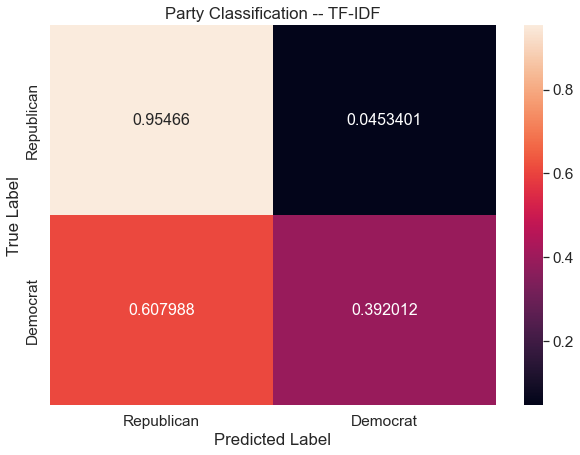

In [262]:
# display confusion matrix

# cf_matrix = cf_matrix.rename(index=str, columns={0: "Republican", 1: "Democrat"})
# df_cm.index = ["Republican", "Democrat"]

df_cm = pd.DataFrame(cf_matrix_p, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Party Classification -- TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 2.2 classify chamber

### 3. Embeddings

In [263]:
#doc_average_embeddings has alredy been prepared to match congress_tweets in length

#### 3.1 classify party

#### 3.2 classify chamber

In [ ]:
doc_average_embeddings

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**